In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q3: Efficient Tracking

Make sure to comment your code and use proper names for your variables.

## Q3.1: Lucas-Kanade with Inverse Composition

In [34]:
from scipy.ndimage import affine_transform
from scipy.interpolate import RectBivariateSpline as RBS
from numpy.linalg import lstsq

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    
    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    # M = np.eye(3)
    # M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your Efficient LK implementation here: 
    p = np.zeros(6)
    dp_thresh = 1
    i = 0
    
    It_spline = RBS(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    It1_spline = RBS(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    
    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    x = np.linspace(0, It1.shape[1], It1.shape[1])
    # print(x.shape)
    y = np.linspace(0, It1.shape[0], It1.shape[0])
    # print(y.shape)
    x_mesh, y_mesh = np.meshgrid(x, y)
    # print(x_mesh.shape)

    It1_grad_x = It1_spline.ev(y_mesh, x_mesh, dx = 1, dy = 0).flatten()
    It1_grad_y = It1_spline.ev(y_mesh, x_mesh, dx = 0, dy = 1).flatten()

    A = np.zeros((It1_grad_x.shape[0], 6))
            
    A[:, 0] = It1_grad_y @ x_mesh.flatten()
    A[:, 1] = It1_grad_y @ y_mesh.flatten()
    A[:, 2] = It1_grad_y 

    A[:, 3] = It1_grad_x @ x_mesh.flatten()
    A[:, 4] = It1_grad_x @ y_mesh.flatten()
    A[:, 5] = It1_grad_x

    while (i <= num_iters) and (dp_thresh >= threshold):        
        x_warped = (1 + p[0]) * x_mesh + p[1] * y_mesh + p[2]
        y_warped = p[3] * x_mesh + (1 + p[4]) * y_mesh + p[5]

        idx_valid = (x_warped > 0) & (x_warped < It.shape[1]) & (y_warped > 0) & (y_warped < It.shape[0])
        
        # idx_valid = (x_mesh > 0) & (x_mesh < It.shape[1]) & (y_mesh > 0) & (y_mesh < It.shape[0])

        # x_warped_valid = x_warped[idx_valid]
        # y_warped_valid = y_warped[idx_valid]

        x_warped_valid = x_warped[idx_valid]
        y_warped_valid = y_warped[idx_valid]
        
        It1_inter = It1_spline.ev(y_warped_valid, x_warped_valid).flatten()
        
        A_valid = A[idx_valid.flatten()]
        
        It_inter = It_spline.ev(y_mesh[idx_valid], x_mesh[idx_valid]).flatten()
        b = It_inter - It1_inter
        # print("b", b)
        
        delta_p, _,_, _ = lstsq(A_valid, b, rcond = None)

        dp_thresh = np.linalg.norm(delta_p)

        # if (dp_thresh < threshold):
        #     print('Below threshold')
        #     print(delta_p)

        M = np.array([[1 + p[0], p[1], p[2]], [p[3], 1 + p[4], p[5]], [0, 0, 1]])
        delta_M = np.array([[1 + delta_p[0], delta_p[1], delta_p[2]], [delta_p[3], 1 + delta_p[4], delta_p[5]],[0, 0, 1]])
        M = M @ np.linalg.inv(delta_M)

        p += delta_p

        i += 1
    
    # ----------------------------------------------------------------------------------------------
    return M[:2, :]

## Q3.1 Subtract Dominant Motion

Re-use your implementation for Q2.2. 

Just make sure to use InverseCompositionAffine within. 

In [35]:
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    mask = np.ones(It1.shape, dtype=bool)

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    M = InverseCompositionAffine(It, It1, threshold, num_iters)
   
    It_warp = cv2.warpAffine(It, M, It1.T.shape)
    
    error = np.absolute(It1 - It_warp)
    mask = error > tolerance #Locations where movement occurs
    mask = binary_dilation(mask, iterations = 5)
    mask = binary_erosion(mask, iterations = 5)


    # ----------------------------------------------------------------------------------------------
    return mask 

## Q3.2: Track Sequence

Re-use your implementation for Q2.3

In [36]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    masks = np.zeros(seq.shape, dtype = bool)
    # print(masks.shape)
    # It = seq[:, :, 0]
    

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i-1]
        It1 = seq[:, :, i]
        
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        # print(mask.shape)
        masks[:, :, i] = mask
        # It = It1

    #works when It stays the same and iterations is 0. Trying something else
    # ----------------------------------------------------------------------------------------------

    # print(masks.shape)
    return masks

### Q3.2: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [37]:
seq = np.load("../data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 1e-2
tolerance = 0.1

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/antseqmasks.npy', masks)

100%|██████████| 124/124 [00:21<00:00,  5.75it/s]


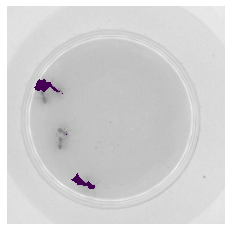

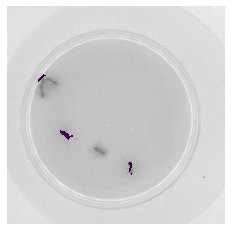

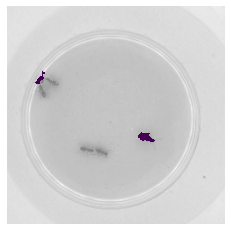

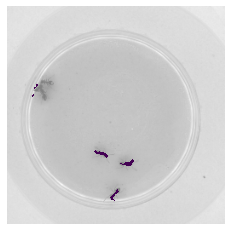

In [38]:
# TODO: visualize. Re-use your implementation for Q2.3
frames_to_save = [29, 59, 89, 119]

masks = np.load('../out/antseqmasks.npy')
# print(masks.shape)
# print(seq[:, :, 29].shape)

# plt.imshow(seq[:, :, 29], cmap="gray", alpha=0.5)

for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]
    # print(mask.shape)
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_3.2_antseq_{idx+1}.png")

### Q3.2: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [39]:
seq_aerial = np.load("../data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 1e-2
tolerance = 0.1

masks_aerial = TrackSequenceAffineMotion(seq_aerial, num_iters, threshold, tolerance)
np.save(f'../out/aerialseqmasks.npy', masks_aerial)

100%|██████████| 149/149 [01:21<00:00,  1.84it/s]


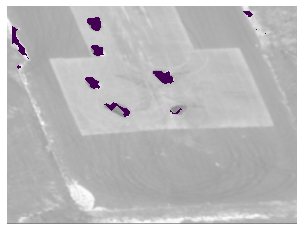

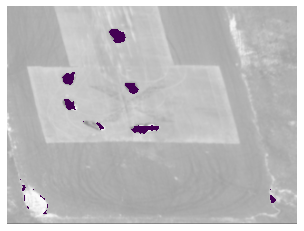

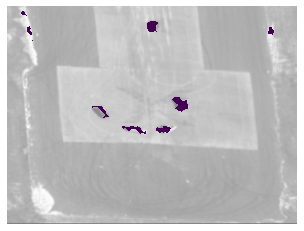

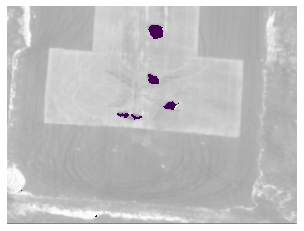

In [40]:
# TODO: visualize. Re-use your implementation for Q2.3
frames_to_save = [29, 59, 89, 119]

masks_aerial = np.load('../out/aerialseqmasks.npy')

for idx in frames_to_save:
    pass
    frame = seq_aerial[:, :, idx]
    mask = masks_aerial[:, :, idx]
    # print(mask.shape)
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_3.2_aerialseq_{idx+1}.png")